In [3]:
import ccxt
import pandas as pd
import configparser
import time
from datetime import datetime, timezone
from tqdm import tqdm

config = configparser.ConfigParser()
config.read("config.ini")
api_key = config.get("settings", "api_key")
secret_key = config.get("settings", "secret_key")


def fetch_binance_data(symbol, type, interval, start_time, end_time):

    exchange = ccxt.binance(
        {
            "apiKey": api_key,
            "secret": secret_key,
            "options": {
                "defaultType": type,
            },
        }
    )

    interval_ms = exchange.parse_timeframe(interval) * 1000

    start_time = (
        int(
            datetime.strptime(start_time, "%d.%m.%y %H:%M:%S")
            .replace(tzinfo=timezone.utc)
            .timestamp()
        )
        * 1000
    )
    end_time = (
        int(
            datetime.strptime(end_time, "%d.%m.%y %H:%M:%S")
            .replace(tzinfo=timezone.utc)
            .timestamp()
        )
        * 1000
    )

    entries_count = (end_time - start_time) // int(interval_ms)
    entries = list()

    with tqdm(total=entries_count, desc=f"Processing {symbol}_{type}") as pbar:
        while entries_count > 0:
            ohlcv = exchange.fetch_ohlcv(
                symbol, interval, since=start_time, limit=min(500, entries_count)
            )
            entries_count = entries_count - len(ohlcv)
            last = ohlcv[-1][0]
            entries.extend(ohlcv)
            start_time = last + 1
            time.sleep(0.1)
            pbar.update(len(ohlcv))
        pbar.close()

    df = pd.DataFrame(
        entries, columns=["timestamp", "open", "high", "low", "close", "volume"]
    )
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    df.set_index("timestamp", inplace=True)
    df["close"] = pd.to_numeric(df["close"])
    df.to_csv(f"{symbol}_{type}_data.csv")

    
symbol_futures = "BTCUSDT"
interval = "1m"
start_date = "01.01.23 00:00:00"
end_date = "01.01.24 00:00:00"

fetch_binance_data(symbol_futures, "future", interval, start_date, end_date)
fetch_binance_data(symbol_futures, "spot", interval, start_date, end_date)

Processing BTCUSDT_spot: 100%|█████████| 525600/525600 [09:28<00:00, 924.08it/s]


В результате проверки, были обнаружены ошибки в массиве данных BTCUSDT_spot за 24.03.2023
Согласно бирже Binance, в период с 11:28 до 17:00 (UTC+3) торги на спотовом рынке были приостановлены в связи с техническим обслуживанием 
(https://www.binance.com/en/support/announcement/binance-spot-trading-system-temporary-maintenance-complete-2023-03-24-813a31506e9f478ea8c1058b425df87a)

Так как количество "битых" данных невелико (порядка 80 записей), можем отбросить их при построении графика

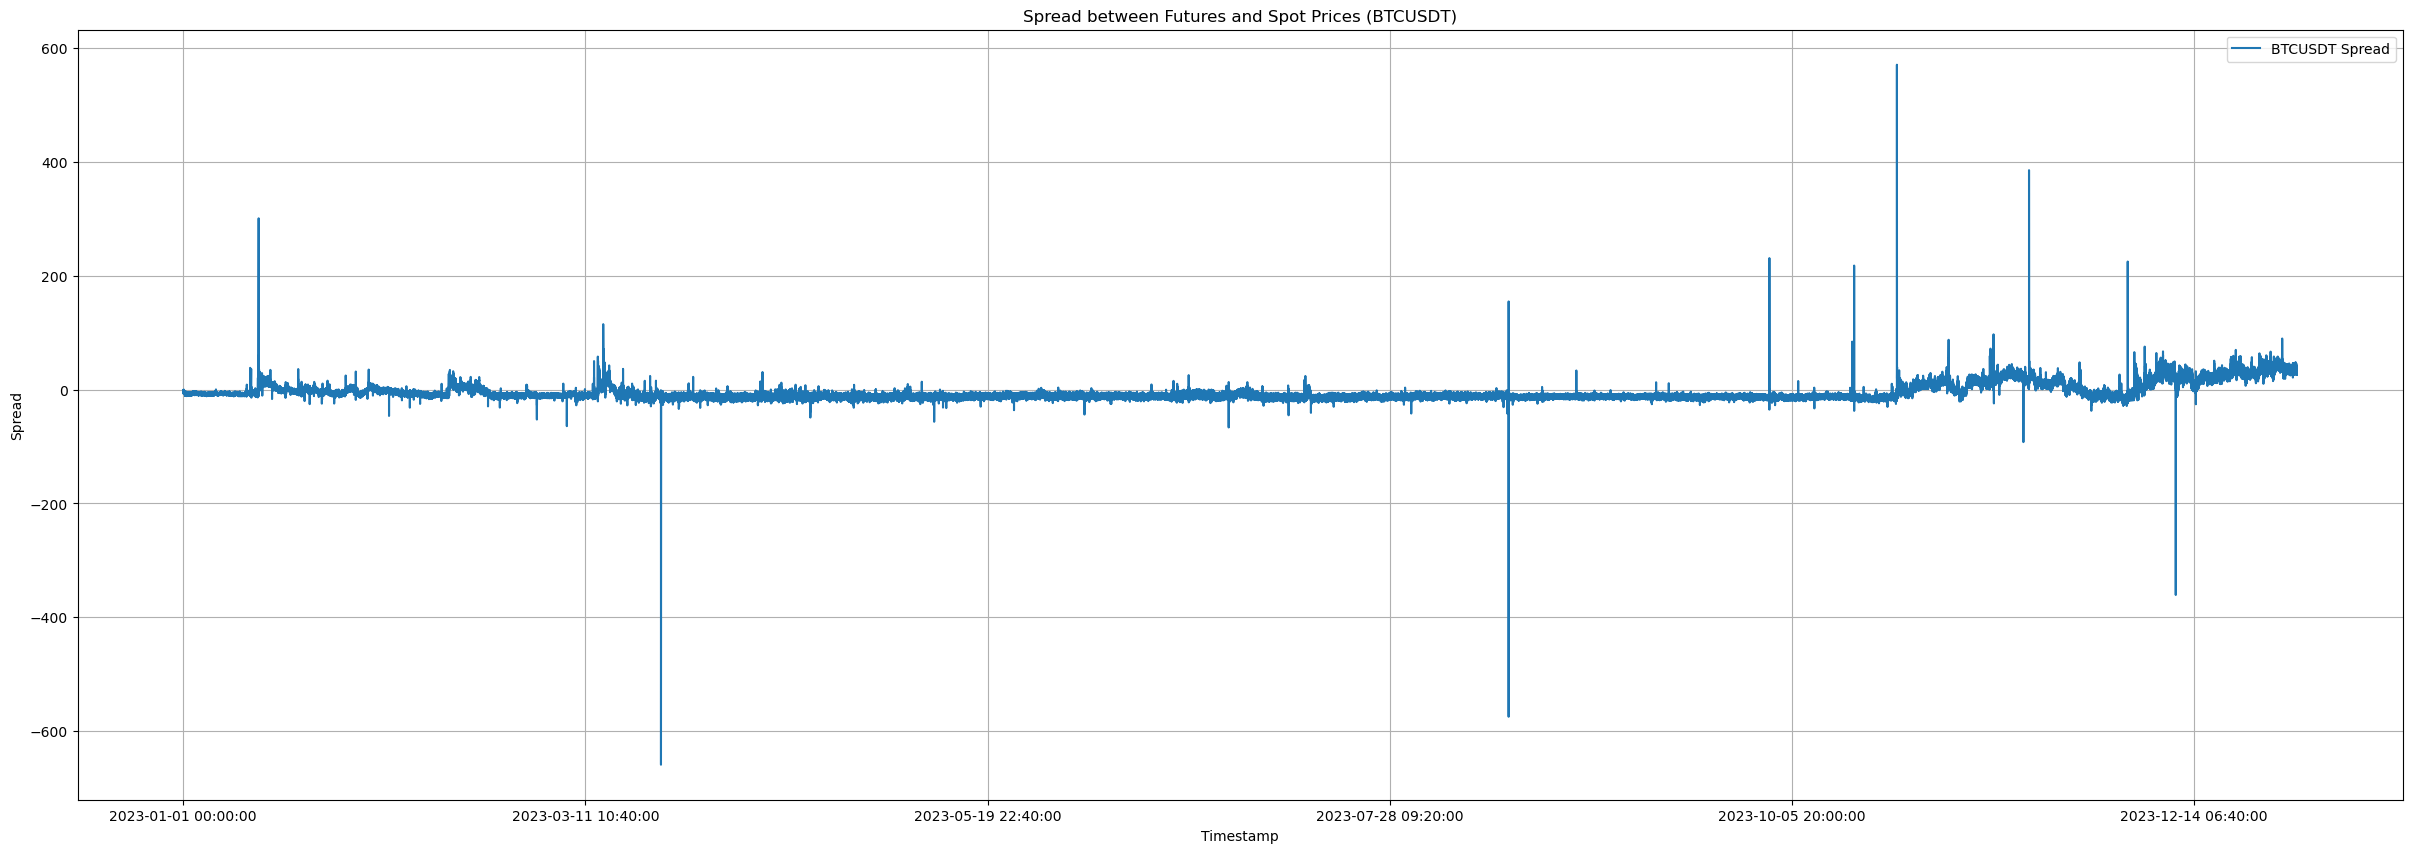

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

pd.options.plotting.backend = "matplotlib"

data_futures = pd.read_csv("BTCUSDT_future_data.csv")
data_spot = pd.read_csv("BTCUSDT_spot_data.csv")

df = pd.merge(data_futures, data_spot, on="timestamp", how="inner", suffixes=("_fut", "_spot"))
spread = pd.Series((df["close_fut"] - df["close_spot"]).array, index=(df["timestamp"]))

spread.plot(figsize=(30, 10))
plt.title("Spread between Futures and Spot Prices (BTCUSDT)")
plt.xlabel("Timestamp")
plt.ylabel("Spread")
plt.legend(["BTCUSDT Spread"])
plt.grid(True)

Также для более релевантного отображения данных, отбросим записи в обоих массивах, когда торги на бирже были приостановлены (объем торгов ["volume"] == 0)

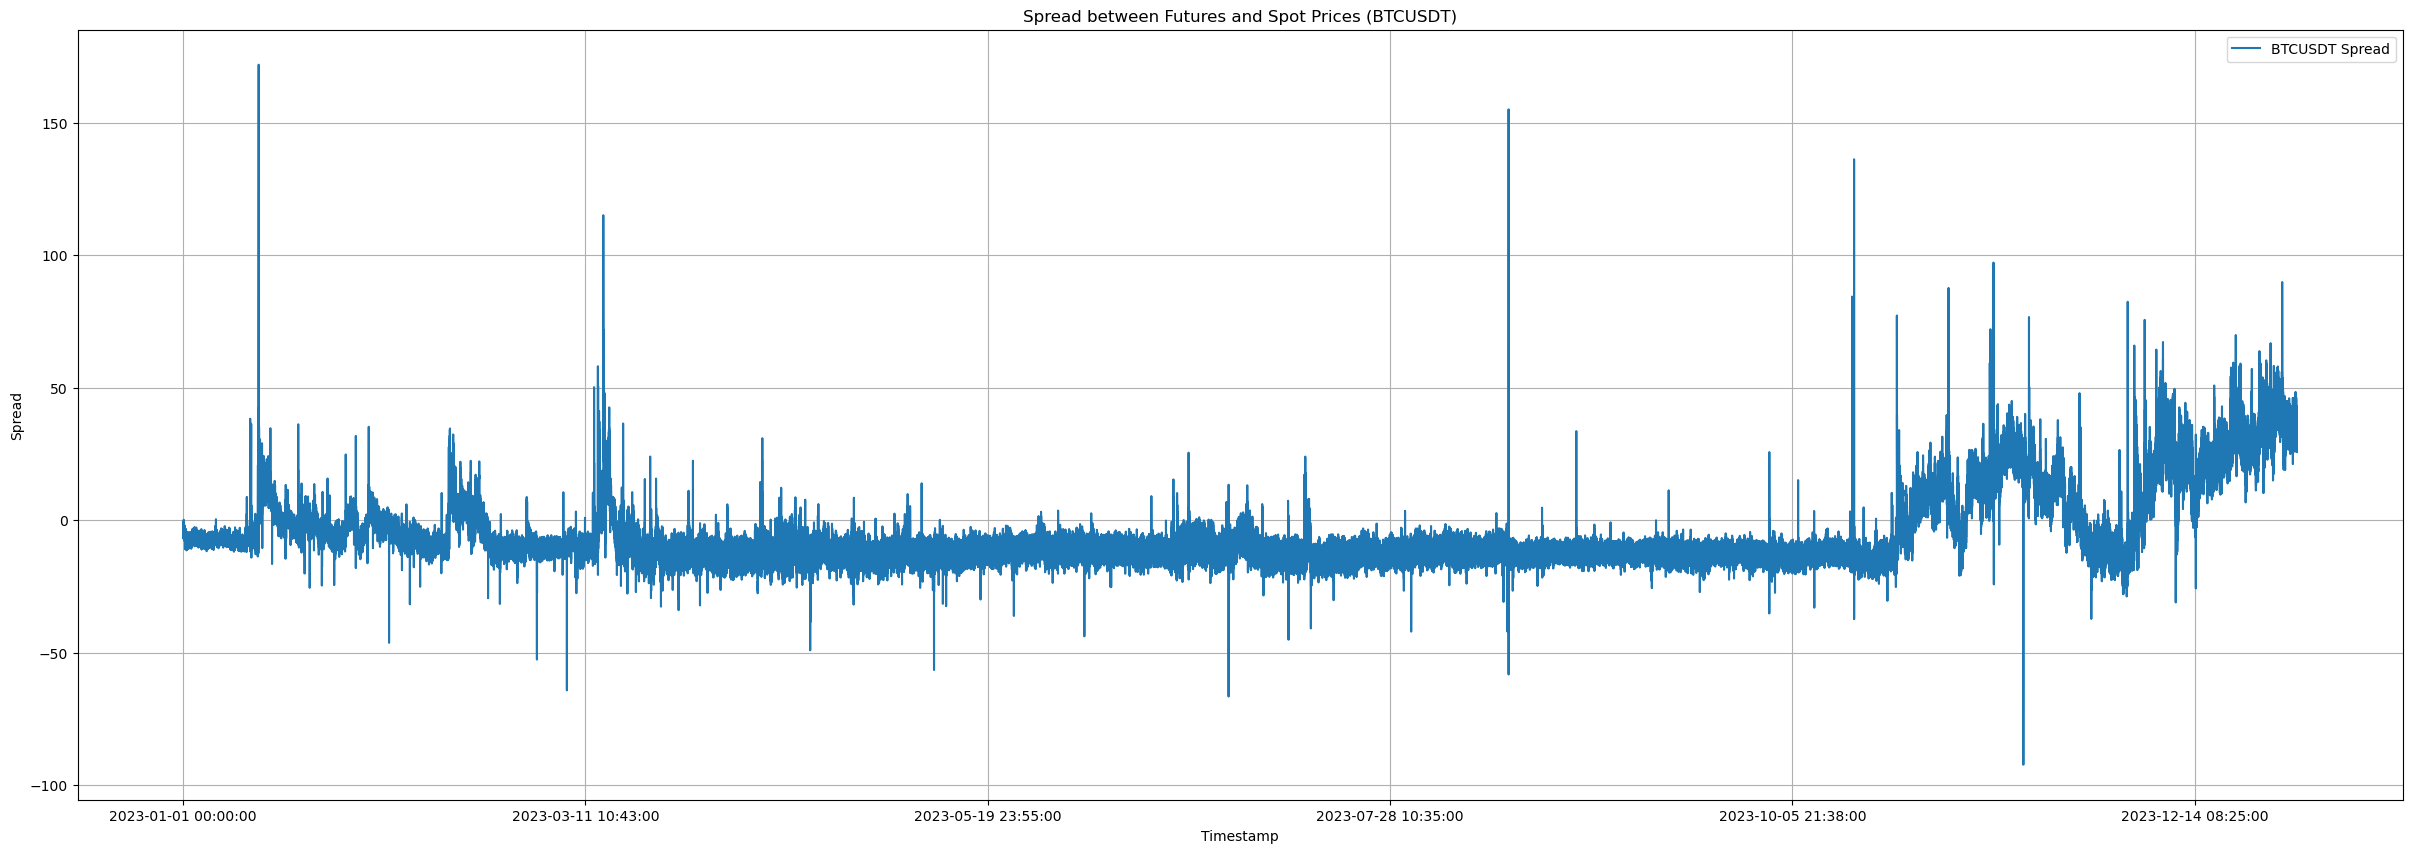

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

pd.options.plotting.backend = "matplotlib"

dfut = data_futures[data_futures["volume"] != 0]
dspot = data_spot[data_spot["volume"] != 0]

df = pd.merge(dfut, dspot, on="timestamp", how="inner", suffixes=("_fut", "_spot"))
spread = pd.Series((df["close_fut"] - df["close_spot"]).array, index=(df["timestamp"]), name='Spread')

spread_condition.plot(figsize=(30, 10))
plt.title("Spread between Futures and Spot Prices (BTCUSDT)")
plt.xlabel("Timestamp")
plt.ylabel("Spread")
plt.legend(["BTCUSDT Spread"])
plt.grid(True)

График иллюстрирует динамику спреда между ценами закрытия минутных свечей фьючерсного контракта BTCUSDT и соответствующего спотового рынка на платформе Binance за 2023 год.

В большинстве случаев, в течение года наблюдается отрицательное значение спреда, указывающее на устойчивую тенденцию, при которой цены фьючерсных контрактов оставались ниже цен на спотовом рынке. Колебания в пределах от -30 до 0 свидетельствуют о стабильной динамике спреда с некоторой степенью волатильности. Отрицательный характер спреда может подчеркивать предпочтение инвесторов держать активы на спотовом рынке или воспринимать текущие спотовые цены как привлекательные.

В четвертом квартале происходит изменение динамики со сменой отрицательного значения на положительное и последующим ростом показателя. Это может указывать на изменение отношения между ценами фьючерсов и спота, либо на изменение общей динамики рынка.
Рост спреда в этот период может быть обусловлен различными факторами, такими как изменения в предложении и спросе, макроэкономические события или изменения во взаимодействии участников рынка.

Также стоит отметить выраженные пики и провалы на графике, которые могут быть связаны с резкими изменениями спроса или предложения на рынке, а также другими факторами, такими как новости, регулирование и т.д. Эти моменты также могут предоставить дополнительный контекст для более глубокого понимания динамики рынка в течение года.